In [ ]:
#importing libraries and google drive data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.patheffects as path_effects
from google.colab import drive
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import roc_auc_score, roc_curve

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Official_Data.csv'
df = pd.read_csv(file_path)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Extent,Instrument,Max Spectral Range (eV),Min Spectral Range (eV),Observable,Source,Thumbnail,Time End,Time Start
0,FULLDISK,T1-HALPHA,1.889194,1.889194,Intensity,SFT,https://solarwww.mtk.nao.ac.jp/mitaka_solar/h...,2025-03-31 00:18:36,2025-03-31 00:18:36
1,FULLDISK,T1-HALPHA,1.889194,1.889194,Intensity,SFT,https://solarwww.mtk.nao.ac.jp/mitaka_solar/h...,2025-03-31 00:18:36,2025-03-31 00:18:36
2,FULLDISK,T1-HALPHA,1.889194,1.889194,Intensity,SFT,https://solarwww.mtk.nao.ac.jp/mitaka_solar/h...,2025-03-31 00:48:42,2025-03-31 00:48:36
3,FULLDISK,T1-HALPHA,1.889194,1.889194,Intensity,SFT,https://solarwww.mtk.nao.ac.jp/mitaka_solar/h...,2025-03-31 00:48:36,2025-03-31 00:48:36
4,FULLDISK,T1-HALPHA,1.889194,1.889194,Intensity,SFT,https://solarwww.mtk.nao.ac.jp/mitaka_solar/h...,2025-03-31 01:18:42,2025-03-31 01:18:42


In [ ]:
#statistics of the data
energy = df['Max Spectral Range (eV)']
print(f"Mean: {energy.mean():,.2f} eV")
print(f"Median: {energy.median():,.2f} eV")
print(f"Standard Deviation: {energy.std():,.2f} eV")
print(f"Variance: {energy.var():,.2f} eV²")
print(f"Minimum: {energy.min():,.2f} eV")
print(f"Maximum: {energy.max():,.2f} eV")
print(df.index)

Mean: 130,285.08 eV
Median: 3.12 eV
Standard Deviation: 2,390,680.82 eV
Variance: 5,715,354,779,382.24 eV²
Minimum: 1.45 eV
Maximum: 100,000,000.00 eV
RangeIndex(start=0, stop=14395, step=1)


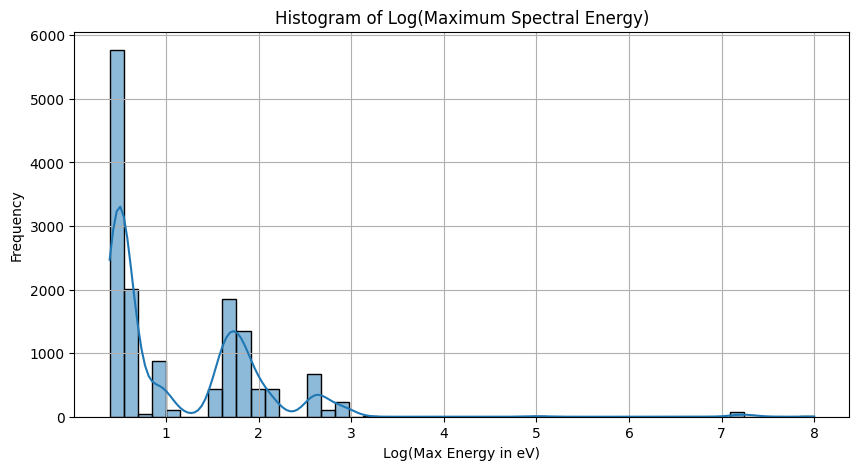

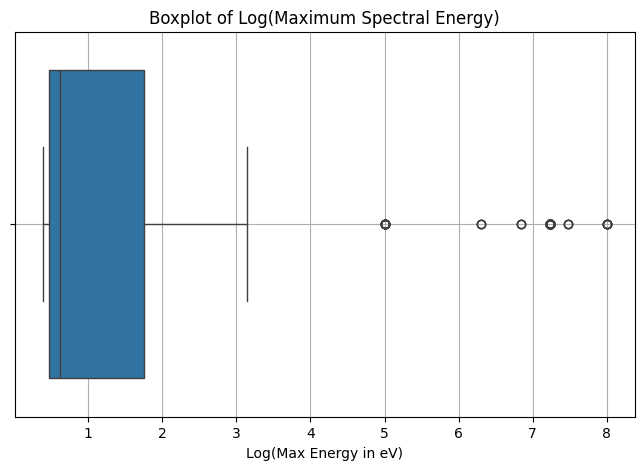

In [ ]:
#applying log due to high skew
df['log_max_energy'] = df['Max Spectral Range (eV)'].apply(lambda x: np.log10(x + 1))

#histogram display
plt.figure(figsize=(10, 5))
sns.histplot(df['log_max_energy'], bins=50, kde=True)
plt.title('Histogram of Log(Maximum Spectral Energy)')
plt.xlabel('Log(Max Energy in eV)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#boxplot display
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['log_max_energy'])
plt.title('Boxplot of Log(Maximum Spectral Energy)')
plt.xlabel('Log(Max Energy in eV)')
plt.grid(True)
plt.show()

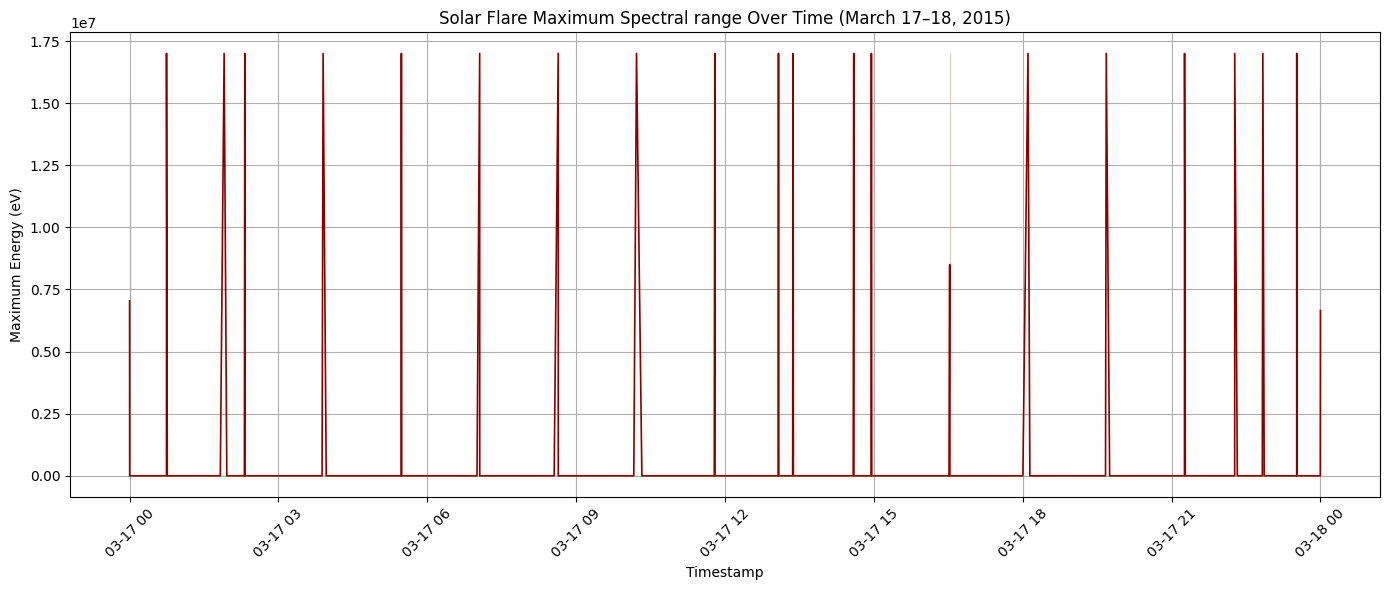

In [ ]:
#parse and sort datetime
df['Time Start'] = pd.to_datetime(df['Time Start'])
df = df.sort_values('Time Start')

#filter to March 17–18, 2015
df_filtered = df[(df['Time Start'] >= '2015-03-17') & (df['Time Start'] <= '2015-03-18')]

#plot for time series of max spectral range
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_filtered, x='Time Start', y='Max Spectral Range (eV)', linewidth=1.2, color='darkred')
plt.title("Solar Flare Maximum Spectral range Over Time (March 17–18, 2015)")
plt.xlabel("Timestamp")
plt.ylabel("Maximum Energy (eV)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

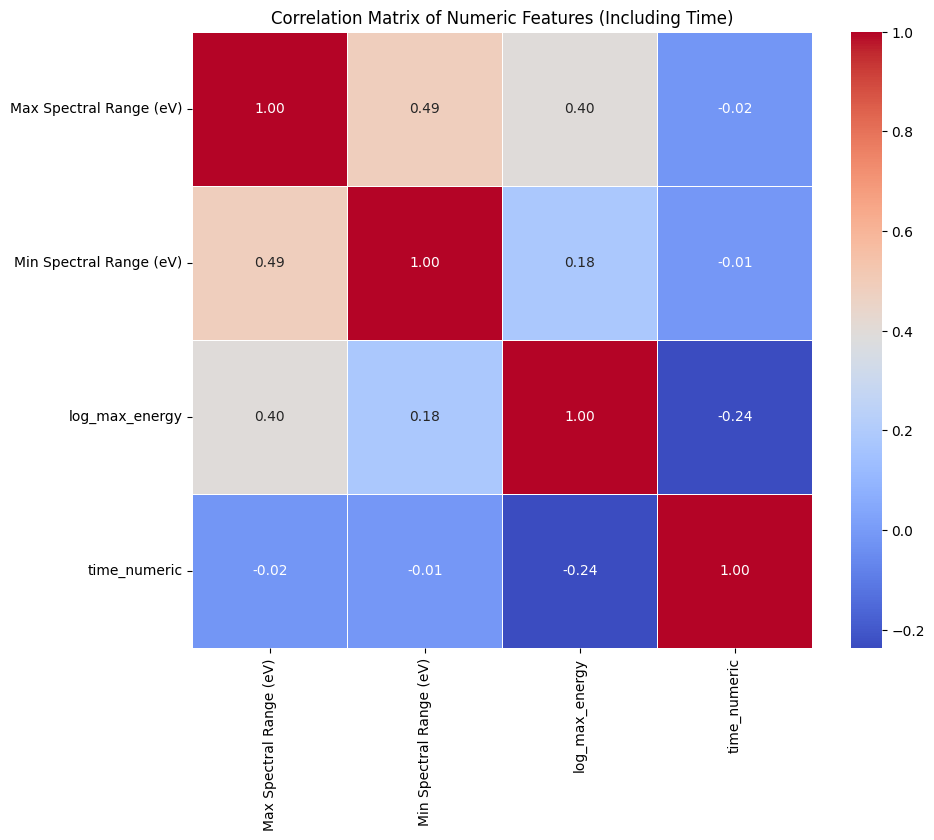

In [ ]:
#convert 'time' column to datetime
df['Time Start'] = pd.to_datetime(df['Time Start'])

#use numeric timestamp
df['time_numeric'] = df['Time Start'].astype('int64') / 1e9  #convert to seconds (from nanoseconds)

#select only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64'])

#compute correlation matrix plot
corr_matrix = numeric_cols.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features (Including Time)")
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


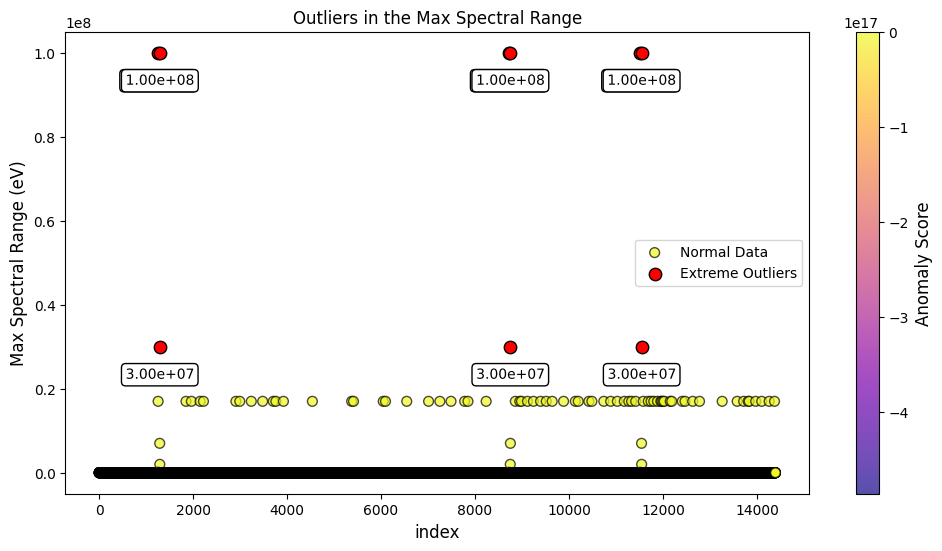

In [ ]:
#incoreration of the local outlier factor in the plot
column_name = 'Max Spectral Range (eV)'
x = df[[column_name]].values
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
df['Anomaly_Score'] = -lof.fit_predict(x)
df['Anomaly_LOF'] = lof.negative_outlier_factor_
threshold = np.percentile(df['Anomaly_LOF'], 0.1)
plt.figure(figsize=(12, 6))
sc = plt.scatter(df.index, df[column_name], c=df['Anomaly_LOF'], cmap='plasma', edgecolors='black', s=50, alpha=0.7)

#created a for loop for the local outlier threshold
for i in range(len(df)):
  if df['Anomaly_LOF'].iloc[i] < threshold:
    plt.scatter(df.index[i], df[column_name].iloc[i], color='red', s=80, edgecolors='black')
    y_offset = -0.05 * (df[column_name].max() - df[column_name].min())
    x_offset = 0
    va = 'bottom' if df[column_name].iloc[i] < df[column_name].median() else 'top'

    #annotates with the background padding for clarity (OpenAI)
    text = plt.text(df.index[i], df[column_name].iloc[i] + y_offset, f'{df[column_name].iloc[i]:.2e}', ha='center', va=va, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    #adds the outline for better point visablity (OpenAI)
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),path_effects.Normal()])

#setup for the plot
cbar = plt.colorbar(sc)
cbar.set_label('Anomaly Score', fontsize=12)
plt.xlabel('index', fontsize=12)
plt.ylabel(column_name, fontsize=12)
plt.legend(['Normal Data', 'Extreme Outliers'], loc='center right')
plt.title('Outliers in the Max Spectral Range')
plt.show()

#OpenAI. (2025). ChatGPT [Large language model]. https://chat.openai.com/chat
#The use of the Local Outlier Factor method is based on the example from the scikit-learn documentation:
#https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


ROC-AUC Score: 0.554


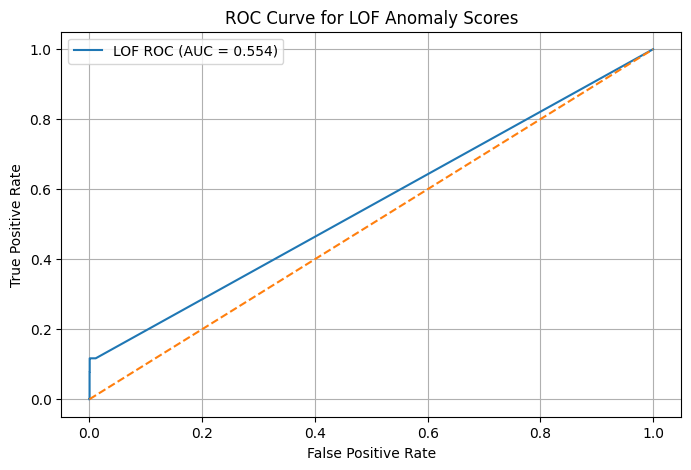

In [ ]:
#create a synthetic label column
threshold = 1e7
df['label'] = (df['Max Spectral Range (eV)'] > threshold).astype(int)

#applying the LOF
X = np.log1p(df[['Max Spectral Range (eV)']])
lof = LocalOutlierFactor(n_neighbors=20, novelty=False)
lof_scores = -lof.fit_predict(X)
lof_anomaly_score = -lof.negative_outlier_factor_

#computing ROC (OpenAI)
roc_auc = roc_auc_score(df['label'], lof_anomaly_score)
print(f"ROC-AUC Score: {roc_auc:.3f}")

#ploting ROC Curve (OpenAI)
fpr, tpr, thresholds = roc_curve(df['label'], lof_anomaly_score)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'LOF ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for LOF Anomaly Scores")
plt.legend()
plt.grid(True)
plt.show()

#OpenAI. (2025). ChatGPT [Large language model]. https://chat.openai.com/chat